<a href="https://colab.research.google.com/github/davidfague/Model-Reduction-Methods/blob/main/Expansion_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron
!pip install neuron_reduce
!git clone https://github.com/davidfague/Model-Reduction-Methods.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 38.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Model-Reduction-Methods'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 341 (delta 15), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (341/341), 1.26 MiB | 7.61 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [2]:
%cd Model-Reduction-Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import analysis functions
from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology

import pandas as pd

/content/Model-Reduction-Methods


In [3]:
%cd expand_example
# compile the mod files
!nrnivmodl mod

/content/Model-Reduction-Methods/expand_example
/content/Model-Reduction-Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../mod/CaDynamics_E2.mod
 -> NMODL ../mod/Ca_HVA.mod
 -> Compiling mod_func.cpp
 -> NMODL ../mod/Ca_LVAst.mod
Translating CaDynamics_E2.mod into /content/Model-Reduction-Methods/expand_example/x86_64/CaDynamics_E2.c
Thread Safe
 -> NMODL ../mod/epsp.mod
Translating Ca_HVA.mod into /content/Model-Reduction-Methods/expand_example/x86_64/Ca_HVA.c
Translating Ca_LVAst.mod into /content/Model-Reduction-Methods/expand_example/x86_64/Ca_LVAst.c
Thread Safe
 -> NMODL ../mod/Ih.mod
Translating epsp.mod into /content/Model-Reduction-Methods/expand_example/x86_64/epsp.c
Th

In [4]:
# check mechanisms

In [5]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


##Define The Cell

In [6]:
#Run the code
from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

#Create a L5_PC model
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')
h.load_file('L5PCbiophys3.hoc')
h.load_file("import3d.hoc")
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

Add synapses to the cell

In [7]:
#Add synapses to the model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

Simulate the complex cell

In [8]:
soma_v = h.Vector()
soma_v.record(complex_cell.soma[0](0.5)._ref_v)

time_v = h.Vector()
time_v.record(h._ref_t)

h.tstop = 1000
st = time.time()
h.run()
print('complex cell simulation time {:.4f}'.format(time.time()-st))
complex_cell_v = list(soma_v)

complex cell simulation time 39.8388


## Use Neuron_Reduce to turn each dendritic tree into a semi-equivalent cable

reduced cell simulation time 1.1634


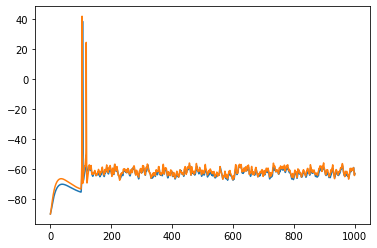

In [9]:
#apply Neuron_Reduce to simplify the cell
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
for r in randoms_list:r.seq(1) #reset random


#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
reduced_celll_v = list(soma_v)

#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.legend()
plt.show()

## Use cable_expander to turn each cable into an equivalent idealized dendritic tree

In [10]:
#trying to automate sections_to_expand and furcations_x after getting branching segment from seg_to_seg dictionary
#problem is that sections_to_expand entry is a string

#indicate the complex branching segment # may have to observe complex cell first
complex_branching_segment='L5PCtemplate[0].apic[36](0.961538)'
#get the reduced segment that the complex nexus branching segment mapped to
branching_seg=txt.get(complex_branching_segment)
branching_seg = branching_seg.replace("[0]", "",1)
branching_seg="reduced_cell.hoc_"+branching_seg
print('branching_seg: ',branching_seg)

# get section_to_expand and the furcation x loc
branching_seg_data=branching_seg.split('(')
section_to_expand=branching_seg_data[0]
furcation_x=branching_seg_data[1].strip(')')
#indicate lists for cable_expander()
sections_to_expand=[section_to_expand]
furcations_x=[furcation_x]
nbranches=[4] #choose nbranches #possible implementation could automatically count the number of times the seg immediately branches, but would not necessary account for later branching

branching_seg:  reduced_cell.hoc_model.apic[0](0.289004)


In [11]:
sections_to_expand = [reduced_cell.hoc_model.apic[0]]
furcations_x=[0.289004]

In [12]:
reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

keep this section
keep this section
keep this section
keep this section
keep this section
trunk_diam: 3.7176523208618155 |trunk_length: 698.0975964944687 |branch_diam: 1.475351301247016 |branch_length: 1081.9141048660235
expanded_seg:  model[1].apic[0](0.0934238)
expanded_seg:  model[1].apic[0](0.27547)
expanded_seg:  model[1].apic[0](0.457518)
expanded_seg:  model[1].apic[0](0.63957)
expanded_seg:  model[1].apic[0](0.821625)


In [13]:
reduced_dendritic_cell.hoc_model

model[1]

In [14]:
#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
expanded_cellll_v = list(soma_v)


reduced cell simulation time 2.1289


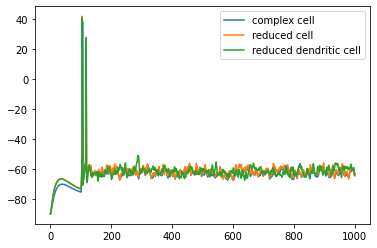

In [15]:
#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.plot(time_v, expanded_cellll_v,  label='reduced dendritic cell')
plt.legend()
plt.show()

Analyze Cells

In [16]:
make_seg_df(complex_cell,"segments_complex.csv")

In [17]:
complex_segments_df=pd.read_csv("segments_complex.csv")

In [18]:
generate_stylized_geometry(cell=complex_cell,savename='geom_complex.csv')

In [19]:
make_reduced_seg_df(reduced_cell,"segments_reduced.csv")

TypeError: ignored

In [ ]:
make_reduced_seg_df(reduced_dendritic_cell,"segments_expanded.csv")

In [ ]:
reduced_segments_df=pd.read_csv("segments_reduced.csv")

In [ ]:
expanded_segments_df=pd.read_csv("segments_expanded.csv")

In [ ]:
plot_morphology(complex_segments_df,'complex_morphology.svg')

In [ ]:
plot_morphology(reduced_segments_df,"reduced_morphology.svg")

In [ ]:
plot_morphology(expanded_segments_df,"expanded_morphology.svg")